In [1]:
import argparse
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_
from src.gradient_masking_tests import gradient_norm, fgsm_pgd_cos_dif, multi_scale_fgsm
import eagerpy as ep
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, ResNet18GradReg
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers, src.gradient_masking_tests

In [2]:
# setup
device = torch.device("cuda")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load CIFAR-10 models

In [3]:
# # Regular CIFAR-10  ResNet Model
model = CIFAR_Res_Net(device).eval()
model.load_state_dict(torch.load("../models/cifar_res_net.model"))
# CIFAR-10  ResNet Model trained with large FGSM steps
fgsm_model = CIFAR_Res_Net(device).eval()
fgsm_model.load_state_dict(torch.load("../models/cifar_res_net_fgsm06.model"))
# # # CIFAR-10  ResNet Model trained with small FGSM steps
fgsm_model_small = CIFAR_Res_Net(device).eval()
fgsm_model_small.load_state_dict(torch.load("../models/cifar_res_net_20e_fgsm03.model"))
# # # CIFAR-10  ResNet Model trained with large Step-ll steps
step_ll_model = CIFAR_Res_Net(device).eval()
step_ll_model.load_state_dict(torch.load("../models/cifar_res_net_20e_stepll.model"))
# # CIFAR-10  ResNet Model trained through input gradient regularization
gradient_norm_model = CIFAR_Res_Net(device).eval()
state_dict = torch.load("D:/Libraries/Documents/tulip/cifar10/logs/cifar10/ResNet18/200e/best.pth.tar")['state_dict']
gradient_norm_model.load_state_dict(state_dict)

<All keys matched successfully>

### Check gradient norms
Gradients seem to blow up after FGSM training

In [14]:
subset_size = 5000
subset = torch.utils.data.Subset(train_dataset, np.random.randint(0, len(test_dataset), size=subset_size).tolist())
subset_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

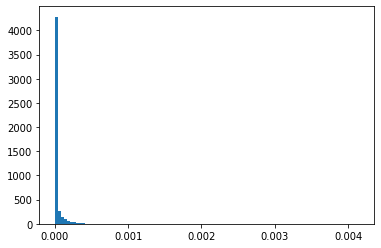

In [12]:
plt.hist(gradient_norm(model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

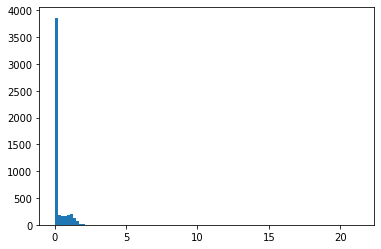

In [13]:
plt.hist(gradient_norm(fgsm_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

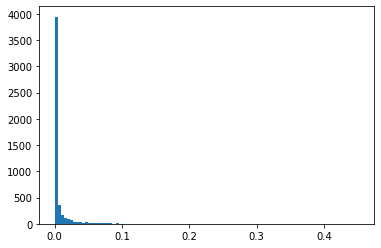

In [15]:
plt.hist(gradient_norm(gradient_norm_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

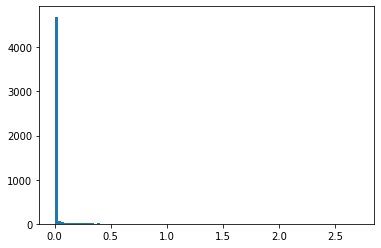

In [12]:
plt.hist(gradient_norm(step_ll_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

### Using train dataset

#### Normal model

In [6]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(model, train_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.10s/it]


(tensor(0.9980, device='cuda:0'),
 tensor(0.9976, device='cuda:0'),
 tensor(1.8028, device='cuda:0'))

In [7]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(4774, device='cuda:0'),
 tensor(5000, device='cuda:0'),
 tensor(4728, device='cuda:0'))

#### FGSM Model

In [8]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(fgsm_model, train_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]


(tensor(0.9973, device='cuda:0'),
 tensor(0.9969, device='cuda:0'),
 tensor(1.9525, device='cuda:0'))

In [9]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(679, device='cuda:0'),
 tensor(5000, device='cuda:0'),
 tensor(2315, device='cuda:0'))

#### Gradient Regularization Model

In [10]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model, train_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.08s/it]


(tensor(0.9979, device='cuda:0'),
 tensor(0.9977, device='cuda:0'),
 tensor(1.7729, device='cuda:0'))

In [11]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(4302, device='cuda:0'),
 tensor(4981, device='cuda:0'),
 tensor(4208, device='cuda:0'))

#### Step-ll Model

In [12]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(step_ll_model, train_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:24<00:00,  2.11s/it]


(tensor(0.9974, device='cuda:0'),
 tensor(0.9977, device='cuda:0'),
 tensor(1.8604, device='cuda:0'))

In [13]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(23, device='cuda:0'),
 tensor(4374, device='cuda:0'),
 tensor(80, device='cuda:0'))

### Using test dataset

#### Normal Model

In [4]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]


(tensor(0.9981, device='cuda:0'),
 tensor(0.9977, device='cuda:0'),
 tensor(1.7800, device='cuda:0'))

In [5]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(4773, device='cuda:0'),
 tensor(5000, device='cuda:0'),
 tensor(4724, device='cuda:0'))

#### FGSM Model

In [6]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(fgsm_model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.05s/it]


(tensor(0.9973, device='cuda:0'),
 tensor(0.9969, device='cuda:0'),
 tensor(1.9531, device='cuda:0'))

In [7]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(1290, device='cuda:0'),
 tensor(5000, device='cuda:0'),
 tensor(2789, device='cuda:0'))

#### Gradient Regularization Model

In [8]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:21<00:00,  2.04s/it]


(tensor(0.9981, device='cuda:0'),
 tensor(0.9977, device='cuda:0'),
 tensor(1.7645, device='cuda:0'))

In [9]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(4350, device='cuda:0'),
 tensor(4974, device='cuda:0'),
 tensor(4272, device='cuda:0'))

#### Step-ll Model

In [4]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(step_ll_model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.29s/it]


(tensor(0.9975, device='cuda:0'),
 tensor(0.9974, device='cuda:0'),
 tensor(1.8622, device='cuda:0'))

In [5]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(2151, device='cuda:0'),
 tensor(4682, device='cuda:0'),
 tensor(2321, device='cuda:0'))